# Term structure of interest rate

- Allahverdili Minaya
- Ibadova Afet

In [1]:
#import Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader.data as web
import datetime as dt
from scipy.interpolate import CubicSpline
from scipy.optimize import newton
from scipy.optimize import minimize

## Discounted cash flow model

In [54]:
def calculate_present_value(cash_flows, discount_rate):
    return sum(cash_flow / ((1 + discount_rate) ** t) for t, cash_flow in enumerate(cash_flows, start=1))

# Bond A details
face_value_a = 1000
coupon_rate_a = 0.05
coupon_frequency_a = 2
years_to_maturity_a = 5

# Bond B details
face_value_b = 1000
coupon_rate_b = 0.06
coupon_frequency_b = 2
years_to_maturity_b = 7

# Assume Term structure of zero-coupon rates
term_structure = {
    1: 0.02,
    2: 0.025,
    3: 0.03,
    4: 0.035,
    5: 0.04,
    6: 0.045,
    7: 0.05
}

# Calculate coupon payments for each bond
coupon_payment_a = (coupon_rate_a * face_value_a) / coupon_frequency_a
coupon_payment_b = (coupon_rate_b * face_value_b) / coupon_frequency_b

# Calculate present value of cash flows for each bond using respective zero-coupon rates
cash_flows_a = [coupon_payment_a] * (years_to_maturity_a * coupon_frequency_a)
cash_flows_a[-1] += face_value_a  # Add face value at maturity
present_value_a = calculate_present_value(cash_flows_a, term_structure[years_to_maturity_a])

print("Bond Price A:", present_value_a)

cash_flows_b = [coupon_payment_b] * (years_to_maturity_b * coupon_frequency_b)
cash_flows_b[-1] += face_value_b  # Add face value at maturity
present_value_b = calculate_present_value(cash_flows_b, term_structure[years_to_maturity_b])

print("Bond Price B:", present_value_b)



Bond Price A: 878.3365633096744
Bond Price B: 802.027181198207


In [61]:
def calculate_ytm(face_value, coupon_payments, years_to_maturity, current_price):

    # Define the YTM equation
    def ytm_equation(y):
        return sum(coupon / ((1 + y) ** t) for t, coupon in enumerate(coupon_payments, start=1)) + \
               (face_value / ((1 + y) ** years_to_maturity)) - current_price

    # Use the newton method to find the root (YTM)
    ytm = newton(ytm_equation, 0.05)  # starting with 5% as an initial guess
    
    return ytm

# Calculate yields (YTM) for each bond
ytm_a = calculate_ytm(face_value_a, cash_flows_a, years_to_maturity_a, present_value_a)
ytm_b = calculate_ytm(face_value_b, cash_flows_b, years_to_maturity_b, present_value_b)

# Print YTM
print("YTM_a:", ytm_a)
print("YTM_b:", ytm_b)


# Compare the yields
if ytm_a > ytm_b:
    print("Bond A has a higher yield.")
elif ytm_a < ytm_b:
    print("Bond B has a higher yield.")
else:
    print("Both bonds have the same yield.")


YTM_a: 0.1482353428907234
YTM_b: 0.12876536881244127
Bond A has a higher yield.


A higher YTM generally indicates **a higher potential return for investors**. It implies that Bond A offers a higher yield or interest rate compared to Bond B, considering the bond's current market price, face value, coupon payments, and time to maturity. Investors may find **Bond A more attractive** because it provides a relatively higher return on their investment.

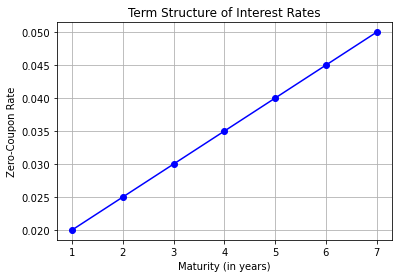

In [58]:
# Plotting the term structure
maturities = list(term_structure.keys())
zero_coupon_rates = list(term_structure.values())

plt.plot(maturities, zero_coupon_rates, marker='o', linestyle='-', color='blue')
plt.xlabel('Maturity (in years)')
plt.ylabel('Zero-Coupon Rate')
plt.title('Term Structure of Interest Rates')
plt.grid(True)
plt.show()

The graph illustrates the term structure of interest rates, showing how the zero-coupon rates vary across different maturities. The shape of the graph provides insights into the expectations and risk perceptions of market participants.

- If the yield curve is **upward sloping**, it indicates that ***long-term interest rates are higher than short-term rates, which suggests expectations of future inflation or economic growth.***
- If the yield curve is **downward sloping (inverted**), it implies that ***long-term interest rates are lower than short-term rates, which could signal expectations of an economic downturn or lower future inflation***.
- If the yield curve is **flat**, it suggests that ***short-term and long-term interest rates are similar, indicating stability or uncertainty in the economy***.

## Bootstrapping

Bootstrapping is a method used to construct a yield curve by using the prices of fixed-income securities, typically bonds, with different maturities. The term "bootstrapping" refers to the process of ***iteratively deriving the prices or yields of zero-coupon bonds from the observed market prices of coupon-bearing bonds***. It is based on the principle that the present value of cash flows from a bond should be equal to its market price.

In the below-mentioned code,bootstrapping process involves the following steps:

- **Obtaining bond market data:** for our case, the code fetches US Treasury bond data from the FRED database.

- **Calculating bond prices:** The bond prices are calculated by discounting the bond's future cash flows (coupons and principal) using the bond yield.

- **Calculating discount factors:** Discount factors are calculated based on the bond prices. Discount factors represent the present value of a future cash flow.

- **Calculating the zero-coupon curve:** The zero-coupon curve is derived by taking the reciprocal of the discount factors raised to the power of 1 divided by the corresponding time period. This provides the zero-coupon rates for each time period.

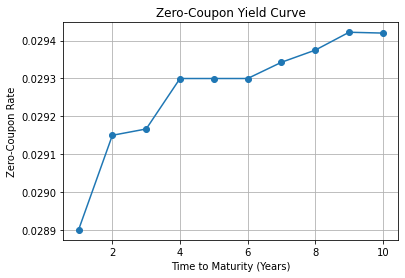

In [29]:
def bootstrap_term_structure(coupon_rate, time_to_maturity):
    # Fetch US Treasury bond data using pandas_datareader
    bond_data = web.DataReader('DGS10', 'fred')
    bond_data = bond_data.iloc[:time_to_maturity]  # Limit the data to the desired time to maturity
    
    # Calculate the bond prices
    bond_prices = (100 - coupon_rate * bond_data) / 100
    
    # Calculate the discount factors
    discount_factors = np.zeros(time_to_maturity)
    for i in range(time_to_maturity):
        if i == 0:
            discount_factors[i] = 1 / (1 + bond_data.iloc[i] / 100)
        else:
            discount_factors[i] = discount_factors[i-1] / (1 + bond_data.iloc[i] / 100)
    
    # Calculate the zero-coupon curve
    zero_coupon_curve = (1 / discount_factors) ** (1 / np.arange(1, time_to_maturity+1)) - 1
    
    return zero_coupon_curve

# Example usage
coupon_rate = 0.05  # Coupon rate of the bond
time_to_maturity = 10  # Remaining time to maturity in years

zero_coupon_curve = bootstrap_term_structure(coupon_rate, time_to_maturity)

# Plotting the zero-coupon curve
plt.plot(range(1, time_to_maturity+1), zero_coupon_curve, 'o-')
plt.xlabel('Time to Maturity (Years)')
plt.ylabel('Zero-Coupon Rate')
plt.title('Zero-Coupon Yield Curve')
plt.grid(True)
plt.show()


## McCulloch cubic-spline method

The McCulloch cubic-spline method, also known as the McCulloch method, is a technique for constructing smooth curves from a set of data points. 

This method utilizes a mathematical technique called cubic splines ***to interpolate*** between known data points and generate a smooth curve. By constructing a cubic spline curve using the McCulloch method, it becomes possible ***to estimate interest rates for maturities that fall between the observed data points.*** This is particularly useful in financial analysis, as it allows for the interpolation of interest rates for various time horizons, aiding in pricing fixed-income securities, valuing derivatives, and analyzing the term structure of interest rates.

The McCulloch cubic-spline method is widely used in financial modeling and analysis due to ***its ability to capture the smoothness and flexibility of yield curves.***

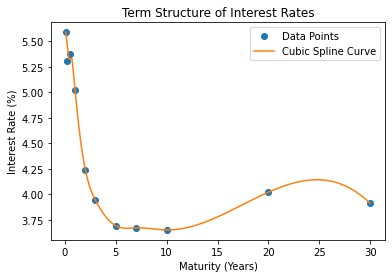

In [80]:
# Define the start and end dates
start_date = dt.datetime(2020, 1, 1)
end_date = dt.datetime(2023, 5, 18)

# Define the Treasury Yield Curve symbols
symbols = ['DGS1MO', 'DGS3MO', 'DGS6MO', 'DGS1', 'DGS2', 'DGS3', 'DGS5', 'DGS7', 'DGS10', 'DGS20', 'DGS30']

# Retrieve the data from FRED
data = web.DataReader(symbols, 'fred', start_date, end_date)

# Extract maturities and corresponding interest rates
maturities = [1/12, 3/12, 6/12, 1, 2, 3, 5, 7, 10, 20, 30]
interest_rates = [data[symbol].values[-1] for symbol in symbols]

# Construct the cubic spline curve
cs = CubicSpline(maturities, interest_rates)

# Generate points for plotting the curve
x = np.linspace(min(maturities), max(maturities), 100)
y = cs(x)

# Plot the curve
plt.plot(maturities, interest_rates, 'o', label='Data Points')
plt.plot(x, y, label='Cubic Spline Curve')
plt.xlabel('Maturity (Years)')
plt.ylabel('Interest Rate (%)')
plt.title('Term Structure of Interest Rates')
plt.legend()
plt.show()


Pros of the McCulloch cubic-spline method:

1. **Smoothness:** The method generates a smooth curve that passes through each data point and has continuous first and second derivatives. This smoothness helps in capturing the underlying trends and patterns in the data.

2. **Flexibility:** The cubic spline curve allows for flexibility in modeling the yield curve. It can handle irregularly spaced data points and can accurately interpolate interest rates for maturities that fall between observed data points.

3. **No assumptions about functional form:** Unlike some other methods used for yield curve estimation, the McCulloch method does not rely on specific assumptions about the functional form of the yield curve. It can capture various shapes and dynamics without imposing rigid constraints.

4. **Interpolation accuracy:** The method provides accurate interpolation between data points, which is essential for estimating interest rates for specific maturities or time horizons that are not directly observed in the data.

Cons of the McCulloch cubic-spline method:

1. **Sensitivity to data points:** The cubic spline curve is highly influenced by the positioning and density of the data points. Sparse or clustered data points can result in erratic or volatile yield curve estimates.

2. **Overfitting potential:** If not carefully controlled, the flexibility of cubic splines can lead to overfitting. Overfitting occurs when the model fits the noise or random variations in the data, resulting in a curve that doesn't generalize well to new data.

3. **Lack of extrapolation:** The McCulloch method is primarily designed for interpolation, meaning it accurately estimates interest rates for maturities within the observed range. However, it may not be reliable for extrapolating interest rates beyond the observed data range.

4. **Interpretability:** While the cubic spline curve provides a smooth representation of the yield curve, it may lack intuitive interpretation compared to other models with explicit parameters or factors.

Overall, the McCulloch cubic-spline method is a valuable tool for estimating yield curves and capturing the smoothness and flexibility of interest rate movements. However, it is essential to be aware of its limitations and exercise caution in its application to ensure accurate and meaningful results.

## Nelson and Siegel method

The Nelson-Siegel model is a popular mathematical model used to estimate the term structure of zero-coupon bonds. It employs a set of parameters to describe the yield curve shape and is based on the idea that the yield curve can be represented as a combination of three factors: ***level, slope, and curvature***. By fitting the Nelson-Siegel model to observed bond prices or yields, the spot rates for zero-coupon bonds with different maturities can be estimated, allowing for the determination of the term structure.

In [68]:
# Nelson-Siegel model equation
def nelson_siegel_model(t, beta0, beta1, beta2, tau):
    return beta0 + beta1 * (1 - np.exp(-t/tau))/ (t/tau) + beta2 * ((1 - np.exp(-t/tau))/ (t/tau) - np.exp(-t/tau))

# Error function to minimize (root mean squared error)
#calculate RMSE between the predicted yields from the model and the observed yields.
def error_function(params, maturities, yields):
    beta0, beta1, beta2, tau = params
    predicted_yields = nelson_siegel_model(maturities, beta0, beta1, beta2, tau)
    return np.sqrt(np.mean((predicted_yields - yields)**2))

# Sample data of bond maturities and yields (example)
maturities = np.array([0.5, 1.0, 1.5, 2.0, 2.5, 3.0])  # Bond maturities in years
yields = np.array([0.018, 0.016, 0.015, 0.014, 0.013, 0.012])  # Bond yields

# Initial guess for parameter values
initial_params = [0.05, -0.02, 0.02, 2.0]

# Minimize the error function to estimate the parameters
result = minimize(error_function, initial_params, args=(maturities, yields))

# Extract the estimated parameters
estimated_params = result.x
beta0, beta1, beta2, tau = estimated_params

# Print the estimated parameters
print("Estimated Parameters:")
print(f"Beta0: {beta0}")
print(f"Beta1: {beta1}")
print(f"Beta2: {beta2}")
print(f"Tau: {tau}")


Estimated Parameters:
Beta0: 0.005145303775714612
Beta1: 0.01464440856998844
Beta2: -1.7412316783911096e-05
Tau: 1.741592561450553



In the Nelson-Siegel model, the parameters β0, β1, β2, and τ are used to describe the shape of the yield curve. These parameters play a crucial role in determining the spot rates for zero-coupon bonds of different maturities. Here's an explanation of each parameter:

- beta0 (Level): β0 represents the level or long-term average level of interest rates. It captures the overall level of the yield curve and influences the spot rates for longer-maturity bonds. ***A higher value of beta0 indicates higher long-term interest rates, while a lower value indicates lower long-term rates.***

- beta1 (Slope): β1 represents the slope or the steepness of the yield curve. It determines how quickly the yield curve transitions from short-term to long-term rates. β1 influences the spot rates for intermediate-maturity bonds. ***A positive value of beta1 indicates an upward-sloping yield curve (normal), while a negative value indicates a downward-sloping yield curve (inverted).***

- beta2 (Curvature): β2 represents the curvature or the convexity of the yield curve. It captures the curvature of the yield curve beyond the slope. β2 influences the spot rates for bonds with long maturities. ***A positive value of beta2 indicates a humped or "U-shaped" yield curve, while a negative value indicates a "V-shaped" yield curve.***

- tau (Factor Loading or Maturity Factor): τ is a factor loading or a maturity factor that determines the speed of adjustment of the yield curve towards its long-term level (β0). It is an exponential decay factor that reflects the rate at which the yield curve converges towards its long-term level as maturity increases. ***Higher values of τ indicate a faster convergence, while lower values indicate a slower convergence.***

Maturity: 0.5 years, Zero-Coupon Rate: 0.0178730099449616
Maturity: 1.5 years, Zero-Coupon Rate: 0.014958209271957325
Maturity: 2.5 years, Zero-Coupon Rate: 0.012913964008737483
Maturity: 3.5 years, Zero-Coupon Rate: 0.011450445151823677
Maturity: 4.5 years, Zero-Coupon Rate: 0.010380258677801495
Maturity: 5.5 years, Zero-Coupon Rate: 0.009580838691739788
Maturity: 6.5 years, Zero-Coupon Rate: 0.008971016159451443
Maturity: 7.5 years, Zero-Coupon Rate: 0.008496315194008406
Maturity: 8.5 years, Zero-Coupon Rate: 0.008119654065496718
Maturity: 9.5 years, Zero-Coupon Rate: 0.007815414468520063
Maturity: 10.5 years, Zero-Coupon Rate: 0.00756562438967527


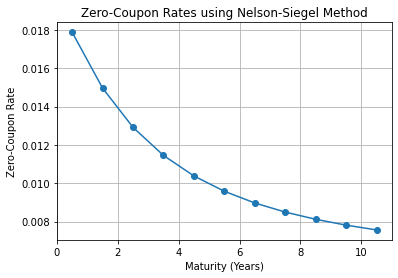

In [79]:
# Set the range of maturities for which you want to calculate the zero-coupon rates
start_maturity = 0.5  # Starting maturity (in years)
end_maturity = 10  # Ending maturity (in years)
step_size = 1  # Step size between maturities (in years)

# Calculate the maturities
maturities = np.arange(start_maturity, end_maturity + step_size, step_size)

# Fetch US Treasury bond data using pandas_datareader
symbol = 'DGS10'  # 10-year Treasury constant maturity rate symbol
bond_data = web.DataReader(symbol, 'fred')

# Calculate the zero-coupon rates
zero_coupon_rates = [nelson_siegel_model(t, beta0, beta1, beta2, tau) for t in maturities]

# Print the calculated zero-coupon rates
for maturity, rate in zip(maturities, zero_coupon_rates):
    print(f"Maturity: {maturity} years, Zero-Coupon Rate: {rate}")

# Plot the zero-coupon rates
plt.plot(maturities, zero_coupon_rates, marker='o')
plt.xlabel('Maturity (Years)')
plt.ylabel('Zero-Coupon Rate')
plt.title('Zero-Coupon Rates using Nelson-Siegel Method')
plt.grid(True)
plt.show()


- The result indicates that for a bond with a maturity of 0.5 years, the estimated zero-coupon rate is approximately 0.0178 or 1.78%.
- The plot shows the term structure of interest rates for the 10-year Treasury bond, based on the Nelson-Siegel model and the provided parameter estimates.

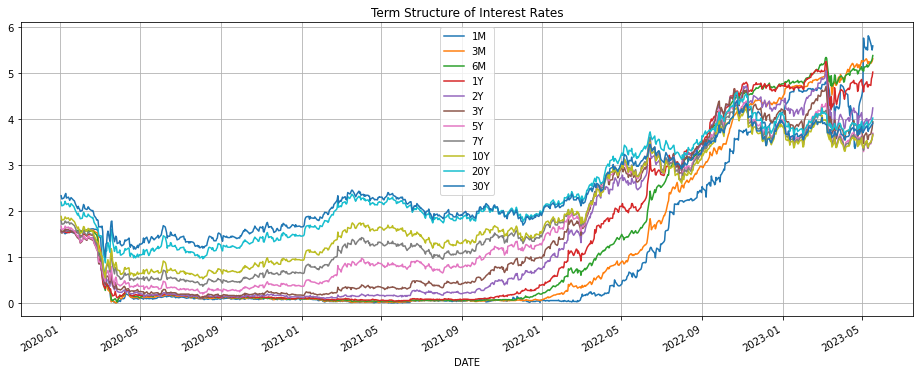

In [8]:
# Define the start and end dates for retrieving the bond yield data
start_date = dt.date(2020, 1, 1)
end_date = dt.date(2023, 5, 18)

# Retrieve the bond yield data from FRED
bond_data = web.DataReader(['DGS1MO', 'DGS3MO', 'DGS6MO', 'DGS1', 'DGS2', 'DGS3', 'DGS5', 'DGS7', 'DGS10', 'DGS20', 'DGS30'], 'fred', start_date, end_date)

# Drop rows with missing values
bond_data.dropna(inplace=True)

# Rename the columns for better readability
bond_data.rename(columns={'DGS1MO': '1M', 'DGS3MO': '3M', 'DGS6MO': '6M', 'DGS1': '1Y', 'DGS2': '2Y', 'DGS3': '3Y', 'DGS5': '5Y', 'DGS7': '7Y', 'DGS10': '10Y', 'DGS20': '20Y', 'DGS30': '30Y'}, inplace=True)

# Plot the term structure of interest rates
bond_data.plot(figsize=(16, 6), grid=True, title='Term Structure of Interest Rates')

# Add explanations as comments
# Define the start and end dates for retrieving the bond yield data
# Retrieve the bond yield data from FRED
# Drop rows with missing values
# Rename the columns for better readability
# Plot the term structure of interest rates

# Display the plot
plt.show()


In [81]:
import time

def fancy_thanks():
    message = "Thanks for your attention!"
    colors = ["\033[91m", "\033[92m", "\033[93m", "\033[94m", "\033[95m", "\033[96m"]
    
    for char in message:
        color = colors.pop(0) if colors else "\033[0m"
        print(color + char, end='', flush=True)
        time.sleep(0.2)
    
    print("\033[0m")  #color
    print("\n")
    print("Wow! Your attention is truly mesmerizing!")
    time.sleep(2)
    print("Thank you for being so captivating!")
    
fancy_thanks()


Thanks for your attention!


Wow! Your attention is truly mesmerizing!
Thank you for being so captivating!
